In [9]:
import numpy as np
import matplotlib.pyplot as plt


In [15]:
#     Numerically stable softmax
def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

#    Simple Layer Normalization

def layer_norm(x, eps=1e-6):
    mean = x.mean(axis=-1, keepdims=True)
    var = ((x - mean) ** 2).mean(axis=-1, keepdims=True)
    return (x - mean) / np.sqrt(var + eps)

#    Sinusoidal positional encoding

def positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, None]
    i = np.arange(d_model)[None, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / d_model)
    angles = pos * angle_rates

    pe = np.zeros((seq_len, d_model))
    pe[:, 0::2] = np.sin(angles[:, 0::2])
    pe[:, 1::2] = np.cos(angles[:, 1::2])

    return pe


In [11]:
class MultiHeadAttention:
    def __init__(self, d_model, num_heads):
        assert d_model % num_heads == 0

        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # Learnable projection matrices
        self.WQ = np.random.randn(d_model, d_model) * 0.01
        self.WK = np.random.randn(d_model, d_model) * 0.01
        self.WV = np.random.randn(d_model, d_model) * 0.01
        self.WO = np.random.randn(d_model, d_model) * 0.01

    def split_heads(self, x):
        B, T, D = x.shape
        x = x.reshape(B, T, self.num_heads, self.d_k)
        return x.transpose(0, 2, 1, 3)

    def forward(self, x, mask=None):
        Q = x @ self.WQ
        K = x @ self.WK
        V = x @ self.WV

        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)

        scores = Q @ K.transpose(0, 1, 3, 2)
        scores = scores / np.sqrt(self.d_k)

        if mask is not None:
            scores = np.where(mask == 0, -1e9, scores)

        attn_weights = softmax(scores, axis=-1)
        output = attn_weights @ V

        output = output.transpose(0, 2, 1, 3)
        output = output.reshape(x.shape)

        return output @ self.WO, attn_weights


In [12]:
class FeedForward:
    def __init__(self, d_model, hidden_dim):
        self.W1 = np.random.randn(d_model, hidden_dim) * 0.01
        self.W2 = np.random.randn(hidden_dim, d_model) * 0.01

    def forward(self, x):
        return np.maximum(0, x @ self.W1) @ self.W2


In [13]:
#    Plot attention heatmap for first batch and first head

def plot_attention(attn_weights, tokens):
    attn = attn_weights[0, 0]

    plt.figure(figsize=(6, 5))
    plt.imshow(attn, cmap="viridis")
    plt.xticks(range(len(tokens)), tokens)
    plt.yticks(range(len(tokens)), tokens)
    plt.colorbar()
    plt.title("Attention Weights")
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.show()


Input embeddings shape: (1, 3, 4)
Final output shape: (1, 3, 4)
Attention row sums (should be 1):
[[[1. 1. 1.]
  [1. 1. 1.]]]
Testing Causal Mask:
[[1. 0. 0.]
 [1. 1. 0.]
 [1. 1. 1.]]

Masked Attention Weights (Head 1):


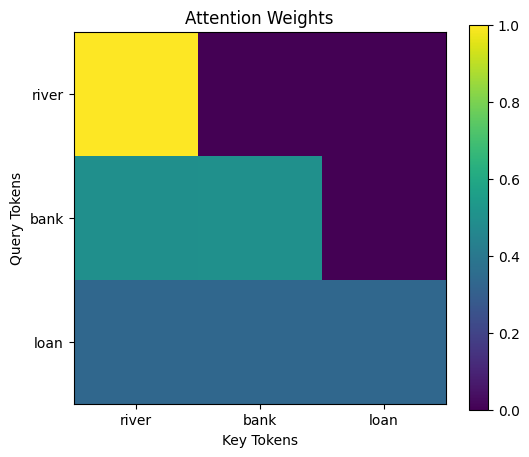

Masked Row Sums (should still be close to 1):
[[[1. 1. 1.]
  [1. 1. 1.]]]


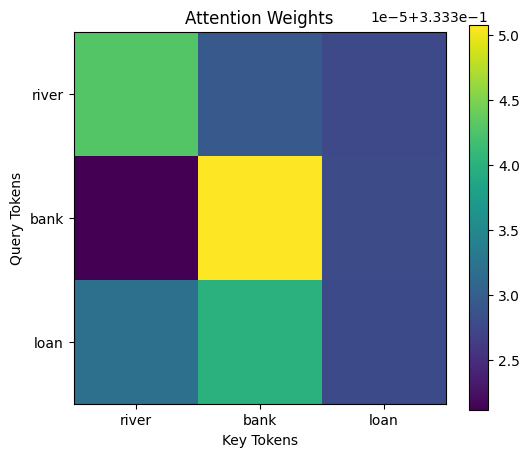

In [16]:

# 1. Toy semantic embeddings

vocab = {
    "river": np.array([1.0, 0.0, 0.0, 0.0]),
    "bank":  np.array([0.9, 0.1, 0.0, 0.0]),
    "loan":  np.array([0.0, 0.9, 0.1, 0.0]),
}

sentence = ["river", "bank", "loan"]

# Shape: (batch_size=1, seq_len=3, d_model=4)

embeddings = np.stack([vocab[w] for w in sentence])[None, :, :]
print("Input embeddings shape:", embeddings.shape)


# 2. Add positional encoding

seq_len = embeddings.shape[1]
d_model = embeddings.shape[2]

pos_enc = positional_encoding(seq_len, d_model)
x = embeddings + pos_enc


# 3. Initialize model

mha = MultiHeadAttention(d_model=d_model, num_heads=2)
ffn = FeedForward(d_model=d_model, hidden_dim=16)


# 4. Attention forward pass

attn_out, attn_weights = mha.forward(x)
x = layer_norm(x + attn_out)


# 5. Feed-forward pass

ffn_out = ffn.forward(x)
x = layer_norm(x + ffn_out)


# 6. Sanity checks

print("Final output shape:", x.shape)
print("Attention row sums (should be 1):")
print(attn_weights.sum(axis=-1))


# 7.  Demonstrate Masking (The "Blind Spot" Fix)

seq_len = x.shape[1]
causal_mask = np.tril(np.ones((1, 1, seq_len, seq_len)))

print("Testing Causal Mask:")
print(causal_mask[0, 0])

# Run Forward Pass WITH Mask
masked_attn_out, masked_weights = mha.forward(x, mask=causal_mask)

# Visualize the Result
print("\nMasked Attention Weights (Head 1):")
plot_attention(masked_weights, sentence)

# Verify the math
print("Masked Row Sums (should still be close to 1):")
print(masked_weights.sum(axis=-1))


# 8. Visualization

plot_attention(attn_weights, sentence)
